In [1]:
#imports
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from models.cnn import SimpleCNN
from models.mlp import MLP
from distillation_utils import Distiller
from invariances_utils import shift_preserving_shape, test_IM
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

ModuleNotFoundError: No module named 'torchmetrics'

In [ ]:
"""
4 exp 4 temps
self dist
self dist shifted
mlp vanilla
cnn vanilla
cnn mlp 
cnn stupider + mlp
fidelity of mlp to t' cross fidelity wrt first cnn - 1 plot

accuracy 
NLL ECE top1 agreement between teacher and student,
KL divergence, invariance metric (crossentropy?) -> show patrick it's better
"""

In [2]:
in_channels = 1
num_classes = 10
num_conv_layers = 2
temperature = 1
num_epochs = 10
batch_size = 64
lr = 0.001
TRAIN = False
device = 'cuda'
#np.random.seed(42)

In [4]:
TRAIN = True

In [ ]:
# MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
#Obtaining CNN
cnn_path = "saved_models/model"
cnn = SimpleCNN(in_channels=in_channels, num_classes=num_classes, num_conv_layers=num_conv_layers, temperature=temperature).to('cuda:0')
if TRAIN:
    criterion_cnn = torch.nn.CrossEntropyLoss()
    optimizer_cnn = torch.optim.Adam(cnn.parameters(), lr=lr)
    # model training
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            outputs = cnn(images.to('cuda'))
            loss = criterion_cnn(outputs, labels.to('cuda'))

            optimizer_cnn.zero_grad()
            loss.backward()
            optimizer_cnn.step()

            if (i + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    # Save the trained model
    torch.save(cnn.state_dict(), cnn_path)
    print(f"Model saved as {cnn_path}!")
if not TRAIN:
    state_dict = torch.load(cnn_path)
    cnn.load_state_dict(state_dict=state_dict)

# Testing the model
cnn.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = cnn(images.to('cuda'))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to('cuda')).sum().item()

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

Epoch [1/10], Step [100/938], Loss: 0.4734
Epoch [1/10], Step [200/938], Loss: 0.5209
Epoch [1/10], Step [300/938], Loss: 0.3167
Epoch [1/10], Step [400/938], Loss: 0.2199
Epoch [1/10], Step [500/938], Loss: 0.1970
Epoch [1/10], Step [600/938], Loss: 0.2205
Epoch [1/10], Step [700/938], Loss: 0.2136
Epoch [1/10], Step [800/938], Loss: 0.1104
Epoch [1/10], Step [900/938], Loss: 0.0864
Epoch [2/10], Step [100/938], Loss: 0.0387
Epoch [2/10], Step [200/938], Loss: 0.0503
Epoch [2/10], Step [300/938], Loss: 0.0605
Epoch [2/10], Step [400/938], Loss: 0.2162
Epoch [2/10], Step [500/938], Loss: 0.1300
Epoch [2/10], Step [600/938], Loss: 0.0471
Epoch [2/10], Step [700/938], Loss: 0.1981
Epoch [2/10], Step [800/938], Loss: 0.1020
Epoch [2/10], Step [900/938], Loss: 0.1371
Epoch [3/10], Step [100/938], Loss: 0.1641
Epoch [3/10], Step [200/938], Loss: 0.0665
Epoch [3/10], Step [300/938], Loss: 0.0585
Epoch [3/10], Step [400/938], Loss: 0.0179
Epoch [3/10], Step [500/938], Loss: 0.1069
Epoch [3/10

Obtaining CNN 2

In [ ]:
#Loading undistilled MLP
if TRAIN:
    mlp = MLP(input_dim = 784, output_dim= num_classes, hidden_size= 2048,
        hidden_layers= 4, device='cuda')
    criterion_mlp = torch.nn.CrossEntropyLoss()
    optimizer_mlp = torch.optim.Adam(mlp.parameters(), lr=lr)
    mlp.train(train_loader=train_loader, optimizer=optimizer_mlp, criterion=criterion_mlp, 
              num_epochs=5)
if not TRAIN:
    mlp = MLP(input_dim = 784, output_dim= num_classes, hidden_size= 2048,
            hidden_layers= 4, device='cuda', from_saved_state_dict="saved_models/mlp")
mlp.eval(test_loader=test_loader)

Not using softmax


TypeError: Module.eval() got an unexpected keyword argument 'test_loader'

Not using softmax
Correct normal: 0.9684
Correct shifted: 0.2821
Correct cnn normal: 0.9741
Correct cnn shifted: 0.6051

tensor(0.5334, device='cuda:0')


tensor(0.9933, device='cuda:0')

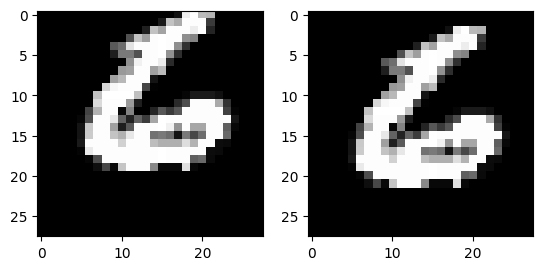

In [6]:
#imports
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from models.cnn import SimpleCNN
from models.mlp import MLP
from distillation_utils import Distiller
from invariances_utils import shift_preserving_shape, test_IM
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
in_channels = 1
num_classes = 10
num_conv_layers = 2
temperature = 1
num_epochs = 10
batch_size = 64
lr = 0.001
TRAIN = False
device = 'cuda'
#np.random.seed(42)
# MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

#loading distilled MLP
mlp_student = MLP(input_dim = 784, output_dim= num_classes, hidden_size= 2048,
          hidden_layers= 4, device='cuda')

cnn_path = "saved_models/model"
state_dict = torch.load(cnn_path)
cnn = SimpleCNN(in_channels=in_channels, num_classes=num_classes, num_conv_layers=num_conv_layers, temperature=temperature).to('cuda:0')
cnn.load_state_dict(state_dict=state_dict)
distiller = Distiller(student=mlp_student, teacher=cnn, device='cuda', lr=0.001)

if TRAIN:
    distiller.distill(train_loader, test_loader)
    torch.save(distiller.get_student().state_dict(), "newdistillmethod/distiller")  
else:
    state_dict = torch.load("newdistillmethod/distiller")
    distiller.get_student().load_state_dict(state_dict=state_dict)
    #distiller.eval_student(train_loader)
test_IM(test_loader, distiller.get_student(), cnn, device)

In [5]:
#loading distilled MLP
mlp_student = MLP(input_dim = 784, output_dim= num_classes, hidden_size= 2048,
          hidden_layers= 4, device='cuda')
distiller = Distiller(student=mlp_student, teacher=cnn, device='cuda', lr=0.001)
if TRAIN:
    distiller.distill(train_loader, test_loader)
    torch.save(distiller.get_student().state_dict(), "newdistillmethod/distiller")  
else:
    state_dict = torch.load("newdistillmethod/distiller")
    distiller.get_student().load_state_dict(state_dict=state_dict)
distiller.get_student().eval_loop(train_loader)

Not using softmax


In [6]:
test_IM(test_loader, distiller.get_student())

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [5]:
#Self distilling MLP (only from loaded data)

#Self distillation: mlp_student and mlp teacher coincide #TODO CHECK
mlp_student = MLP(input_dim = 784, output_dim= num_classes, hidden_size= 2048,
            hidden_layers= 4, device='cuda', from_saved_state_dict="saved_models/mlp")
mlp_student.eval(test_loader)
print(test_IM(test_loader, mlp_student))

mlp_teacher = MLP(input_dim = 784, output_dim= num_classes, hidden_size= 2048,
            hidden_layers= 4, device='cuda', from_saved_state_dict="saved_models/mlp")
print(test_IM(test_loader, mlp_teacher))

if TRAIN:
    selfdistiller = Distiller(student=mlp_student, teacher=mlp_teacher, device='cuda', lr=0.001)
    selfdistiller.distill(train_loader, 5, "saved_models_selfdistill/")
    selfdistiller.test_step(test_loader=test_loader)

if not TRAIN:
    print("Loading params")
    selfdistiller = Distiller(student=mlp_student, teacher=mlp_teacher, device='cuda', lr=0.001,
                        load_student_from_path = 'saved_models_selfdistill/distiller')
    selfdistiller.test_step(test_loader=test_loader)


Not using softmax
Test Accuracy: 0.9612
tensor(0.8725, device='cuda:0', grad_fn=<DivBackward0>)
Not using softmax
tensor(0.8738, device='cuda:0', grad_fn=<DivBackward0>)
hfafu
Epoch [1/5], Step [100/938], Student Loss : 0.1635, Total Loss: 0.0442
Epoch [1/5], Step [200/938], Student Loss : 0.0570, Total Loss: 0.0225
Epoch [1/5], Step [300/938], Student Loss : 0.3554, Total Loss: 0.1328
Epoch [1/5], Step [400/938], Student Loss : 0.1317, Total Loss: 0.1042
Epoch [1/5], Step [500/938], Student Loss : 0.2529, Total Loss: 0.0886
Epoch [1/5], Step [600/938], Student Loss : 0.0233, Total Loss: 0.0219
Epoch [1/5], Step [700/938], Student Loss : 0.3350, Total Loss: 0.2302
Epoch [1/5], Step [800/938], Student Loss : 0.0820, Total Loss: 0.0284
Epoch [1/5], Step [900/938], Student Loss : 0.4317, Total Loss: 0.0910
Epoch [2/5], Step [100/938], Student Loss : 0.1460, Total Loss: 0.3145
Epoch [2/5], Step [200/938], Student Loss : 0.6121, Total Loss: 0.2191
Epoch [2/5], Step [300/938], Student Loss :

In [6]:
test_IM(test_loader, selfdistiller.get_student())

tensor(0.8889, device='cuda:0', grad_fn=<DivBackward0>)

In [6]:
#Self Distillation
mlp_student = MLP(input_dim = 784, output_dim= num_classes, hidden_size= 2048,
            hidden_layers= 4, device='cuda')

mlp_teacher = MLP(input_dim = 784, output_dim= num_classes, hidden_size= 2048,
            hidden_layers= 4, device='cuda', from_saved_state_dict="saved_models/mlp")
print(test_IM(test_loader, mlp_teacher))

if TRAIN:
    mlp_mlp_distiller = Distiller(student=mlp_student, teacher=mlp_teacher, device='cuda', lr=0.001)
    mlp_mlp_distiller.distill(train_loader, 5, "saved_models_mlpfrommlp/")
    mlp_mlp_distiller.test_step(test_loader=test_loader)

if not TRAIN:
    print("Loading params")
    mlp_mlp_distiller = Distiller(student=mlp_student, teacher=mlp_teacher, device='cuda', lr=0.001,
                        load_student_from_path = 'saved_models_mlpfrommlp/distiller')
    mlp_mlp_distiller.test_step(test_loader=test_loader)

Not using softmax
Not using softmax
tensor(0.8729, device='cuda:0', grad_fn=<DivBackward0>)
hfafu
Epoch [1/5], Step [100/938], Student Loss : 27.8136, Total Loss: 8.6661
Epoch [1/5], Step [200/938], Student Loss : 188.4176, Total Loss: 11.5220
Epoch [1/5], Step [300/938], Student Loss : 662.5803, Total Loss: 13.8150
Epoch [1/5], Step [400/938], Student Loss : 752.3962, Total Loss: 14.6692
Epoch [1/5], Step [500/938], Student Loss : 609.8974, Total Loss: 14.1995
Epoch [1/5], Step [600/938], Student Loss : 2639.6240, Total Loss: 15.4462
Epoch [1/5], Step [700/938], Student Loss : 2322.1643, Total Loss: 14.6260
Epoch [1/5], Step [800/938], Student Loss : 2393.5117, Total Loss: 14.2670
Epoch [1/5], Step [900/938], Student Loss : 2528.3132, Total Loss: 17.2357
Epoch [2/5], Step [100/938], Student Loss : 2206.9958, Total Loss: 14.5140


KeyboardInterrupt: 

In [14]:
test_IM(test_loader, mlp_mlp_distiller.get_student())

tensor(0.1270, device='cuda:0', grad_fn=<DivBackward0>)

In [18]:
# Define a custom dataset that combines MNIST and additional data
class ShiftAugmentedMNIST(Dataset):
    def __init__(self, mnist_dataset, translation_times : int = 5, max_shift : int = 5):
        self.mnist_dataset = mnist_dataset
        directions = ["u","d","l","r"]
        self.translations = []
        for i in range(len(self.mnist_dataset)):
            img, label = self.mnist_dataset[i]
            img = img.squeeze()
            for t in range(translation_times):
                sh = shift_preserving_shape(img, direction=directions[np.random.randint(0,4)],
                                            max_shift=max_shift).unsqueeze(0)
                if sh is not None:
                    self.translations.append((sh, label))

    def __getitem__(self, index):
        if index < len(self.mnist_dataset):
            return self.mnist_dataset[index]
        else:
            return self.translations[index - len(self.mnist_dataset)]

    def __len__(self):
        return len(self.mnist_dataset) + len(self.translations)

In [25]:
# MNIST dataset with shift invariance
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_augmented_dataset = ShiftAugmentedMNIST(train_dataset)
train_augmented_loader = DataLoader(dataset=train_augmented_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
#Evaluating MLP trained on invariance data
if TRAIN:
    shift_invariant_mlp = MLP(input_dim = 784, output_dim= num_classes, hidden_size= 2048,
        hidden_layers= 4, device='cuda')
    criterion_mlp = torch.nn.CrossEntropyLoss()
    optimizer_mlp = torch.optim.Adam(shift_invariant_mlp.parameters(), lr=lr)
    shift_invariant_mlp.train(train_loader=train_augmented_loader, optimizer=optimizer_mlp, criterion=criterion_mlp, 
              num_epochs=5, save_path_folder = "saved_models_shiftinvariantmlp")
if not TRAIN:
    shift_invariant_mlp = MLP(input_dim = 784, output_dim= num_classes, hidden_size= 2048,
            hidden_layers= 4, device='cuda', from_saved_state_dict="saved_models_shiftinvariantmlp/mlp")
shift_invariant_mlp.eval(test_loader=test_loader)

In [27]:
test_IM(test_loader, shift_invariant_mlp)

tensor(0.0822, device='cuda:0', grad_fn=<DivBackward0>)

In [9]:
#Train student model on MLP trained on invariance data 
mlp_student = MLP(input_dim = 784, output_dim= num_classes, hidden_size= 2048,
            hidden_layers= 4, device='cuda')

mlp_teacher = MLP(input_dim = 784, output_dim= num_classes, hidden_size= 2048,
            hidden_layers= 4, device='cuda', from_saved_state_dict="saved_models_shiftinvariantmlp/mlp")
print("Invariance of teacher:" + str(test_IM(test_loader, mlp_teacher)))

if TRAIN:
    shiftinvmlp_mlp_distiller = Distiller(student=mlp_student, teacher=mlp_teacher, device='cuda', lr=0.001)
    shiftinvmlp_mlp_distiller.distill(train_loader, 5, "saved_models_mlpfromshiftinvariantmlp/")
    shiftinvmlp_mlp_distiller.test_step(test_loader=test_loader)

if not TRAIN:
    print("Loading params")
    shiftinvmlp_mlp_distiller = Distiller(student=mlp_student, teacher=mlp_teacher, device='cuda', lr=0.001,
                        load_student_from_path = 'saved_models_mlpfromshiftinvariantmlp/distiller')
    shiftinvmlp_mlp_distiller.test_step(test_loader=test_loader)

Not using softmax
Not using softmax
Invariance of teacher:tensor(0.0821, device='cuda:0', grad_fn=<DivBackward0>)
Epoch [1/5], Step [100/938], Student Loss : 3.4604, Total Loss: 15.6608
Epoch [1/5], Step [200/938], Student Loss : 2.1550, Total Loss: 3.0418
Epoch [1/5], Step [300/938], Student Loss : 0.2299, Total Loss: 1.6676
Epoch [1/5], Step [400/938], Student Loss : 0.9416, Total Loss: 2.1623
Epoch [1/5], Step [500/938], Student Loss : 1.0407, Total Loss: 3.0659
Epoch [1/5], Step [600/938], Student Loss : 0.8709, Total Loss: 2.0034
Epoch [1/5], Step [700/938], Student Loss : 0.2186, Total Loss: 1.1539
Epoch [1/5], Step [800/938], Student Loss : 0.1631, Total Loss: 1.0458
Epoch [1/5], Step [900/938], Student Loss : 0.4773, Total Loss: 1.4397
Epoch [2/5], Step [100/938], Student Loss : 0.3148, Total Loss: 1.6611
Epoch [2/5], Step [200/938], Student Loss : 0.3473, Total Loss: 3.0052
Epoch [2/5], Step [300/938], Student Loss : 0.5968, Total Loss: 1.6403
Epoch [2/5], Step [400/938], Stud

In [10]:
test_IM(test_loader, shiftinvmlp_mlp_distiller.get_student())

tensor(0.9111, device='cuda:0', grad_fn=<DivBackward0>)

vanilla MLP -> 0.9
CNN over MLP -> 0.6

Self-distilled MLP -> 0.5
MLP over MLP -> 0.5

distilled MLP over data augmented MLP on non augmented dataset -> 0.48

extended MNIST and split the dataset in 2 -> train 2 independent CNNs (or use low teacher fidelity, KL between teachers should be high) get t and t', distill to s and s', compute agreement between t and s' 

repeat process for all temperatures [1,4,8,16] and all random seeds 

Data augmented MLP -> 0.09
(distilled MLP over data augmented MLP on augmented dataset -> 0.1)

change IM measure with temperature

---------------
FABIAN TO DO
----------------------
METRICS:
- test agreement metrics 
- indipendent metrics (ECE, NLL, topk) -> consistent with the literature 
we need to add to the eval process these metrics + have a table of consistence with the literature (what are those metrics for a good mlp/cnn/distilled mlp)
EXPERIMENTS
- Train 2 independent students with the same teacher, you compare the fidelities, if the 2 students have comparable fidelities they agree with the teacher because they generalize well 
train 2 students as the above cell + compute agreement metrics
- test distillation with different temperatures: fix temperatures 1 4 8 16
- different MLP model size + test that the mlp is lower in flops
------------------------
ALREADY DONE:
- compute agreement metrics: how much has the student learnt to predict in the same way as the teacher. 
compute_agreement(student_model, teacher_model) - most of this code already written by Patrick: deepsets/test
_____________________________________
4 exp 4 temps
self dist
self dist shifted
mlp vanilla
cnn vanilla
cnn mlp 
cnn stupider + mlp
fidelity of mlp to t' cross fidelity wrt first cnn - 1 plot

accuracy NLL ECE top1 agreement between teacher and student, KL divergence, invariance metric (crossentropy?) -> show patrick it's better


NICOLE TO DO:
---------------
- try with bigger filter and bigger max pooling
- change IM metric

- rerun all experiments and make pretty plots
- large, heavy, regularized MLP - create a large, heavy, regularized MLP and distill with that
- scale: extended MNIST CIFAR-10 (but cumbersome)
- uncertainties : different seeds 
- 42 101 121 240 308 random seeds 
- non shifted training set + mlp, mlp with distillation on a cnn, run those over test dataset that's shifted -> expect better performance on mlp dist on cnn
- give shifted validation set performance (validation set loss)
- test val set accuracy with alpha different

 
TO DO TOMORROW:
- understand the softmax thing
- plotting with different temperatures

We need to have consistent:
- training
- distillation
- indipendent metrics (ECE, NLL, topk) -> consistent with the literature 
- fidelity metrics
----------------------------
- self distilling mlp
- fix the distillation loss problem
- distill an mlp over an mlp
- train an mlp independently on shifted data - compares with unshifted but distilled 
------------------------------------------


the model actually learns invariances through the teacher -> all of these results hold


ECE,  